## IMPORTING LIBRARIES

In [101]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
from datetime import datetime
from sklearn.covariance import LedoitWolf


## DOWNLOADING DATA

In [102]:
TICKERS = [
    # Large-cap tech & communication
    "AAPL","MSFT","GOOGL","AMZN","TSLA","META","NVDA","NFLX","ADBE","CRM",

    # Semiconductors
    "INTC","AMD","QCOM","AVGO","TXN","MU","AMAT","LRCX","NXPI","KLAC",

    # Banks & financials
    "JPM","BAC","WFC","C","GS","MS","V","MA","PYPL","AXP",

    # Healthcare & pharma
    "PFE","JNJ","MRK","UNH","ABBV","LLY","BMY","GILD","AMGN","REGN",

    # Energy
    "XOM","CVX","BP","SHEL","TTE","COP","SLB","HAL","MPC","PSX",

    # Consumer staples & discretionary
    "PG","KO","PEP","WMT","COST","HD","MCD","NKE","TGT","SBUX",

    # Industrials
    "BA","CAT","DE","HON","GE","UPS","MMM","LMT","RTX","FDX",

    # Utilities
    "NEE","DUK","SO","AEP","EXC","SRE","WEC","PEG","ED","XEL",

    # Telecom
    "VZ","T","TMUS","CMCSA","CHTR","DIS","FOX","FOXA","ROKU",

    # More large-caps for diversity
    "ORCL","IBM","SAP","CSCO","MMM","BKNG","SPGI","BLK","MO","PM",
    "ADSK","WDAY"
]

In [103]:

END = datetime.today().strftime("%Y-%m-%d")
RISK_FREE_RATE = 0.035
ANNUAL_TRADING_DAYS = 252
OUTPUT_DIR = "optiverse_outputs"

L2_REG = 1e-2
EPS_JITTER = 1e-5
ALLOW_SHORT = False
N_POINTS = 50
os.makedirs(OUTPUT_DIR, exist_ok=True)

LOOKBACK_YEARS = [3, 5, 10]
MIN_DATA_FRACTION = 0.9

In [104]:
#this function is used to download the prices from yfinance for the following stocks in tickers from the dates containing from start to end.
#and placing them properly in a dataframe.
def download_prices(tickers, start, end=END):
    raw = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)
    if raw.empty:
        raise RuntimeError("yfinance returned no data for the given tickers / date range.")
    if isinstance(raw.columns, pd.MultiIndex):
        if "Adj Close" in raw.columns.get_level_values(0):
            df = raw["Adj Close"]
        elif "Close" in raw.columns.get_level_values(0):
            df = raw["Close"]
        else:
            df = raw.xs(raw.columns.levels[0][-1], axis=1, level=0, drop_level=True)
    else:
        if "Adj Close" in raw.columns:
            df = raw["Adj Close"]
        elif "Close" in raw.columns:
            df = raw["Close"]
        else:
            df = raw
    if isinstance(df, pd.Series):
        df = df.to_frame()
    df = df.dropna(how="all")
    if list(df.columns) != list(tickers) and len(df.columns) == len(tickers):
        try:
            df.columns = tickers
        except Exception:
            pass
    return df

In [105]:
# We drop any ticker that does NOT have at least MIN_DATA_FRACTION (90%) of the required
# trading days for the window. Missing data would otherwise break covariance estimation
# and produce unstable or inaccurate results.
def filter_tickers_by_history(prices, required_days):
    avail = prices.notna().sum()
    kept = list(avail[avail >= required_days].index)
    dropped = list(avail[avail < required_days].index)
    return kept, dropped


## SOLVER

In [106]:
#in solve markovwitx funtion we use solvers like OSQP,ECOS,SCS to solve the optimization problem. 
# these solvers essentially solve the KKT and largarian conditions
#and we return the optimal weights allocations . we use l2 regularisation

def solve_markowitz(mu, Sigma, R_target, allow_short=False, l2_reg=0.0):
    n = Sigma.shape[0]
    w = cp.Variable((n, 1))
    objective = cp.quad_form(w, Sigma)
    if l2_reg and l2_reg > 0:
        objective = objective + l2_reg * cp.sum_squares(w)
    constraints = [cp.sum(w) == 1, mu.T @ w >= R_target]
    if not allow_short:
        constraints.append(w >= 0)
    prob = cp.Problem(cp.Minimize(objective), constraints)

    # Trying OSQP with stricter tolerances first
    try:
        prob.solve(solver=cp.OSQP, verbose=False, max_iter=200000, eps_abs=1e-6, eps_rel=1e-6)
    except Exception:
        pass
    # fallback to ECOS
    if prob.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        try:
            prob.solve(solver=cp.ECOS, verbose=False, max_iters=100000)
        except Exception:
            pass
    # last fallback to SCS
    if prob.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        try:
            prob.solve(solver=cp.SCS, verbose=False, max_iters=25000)
        except Exception:
            pass

    if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        w_opt = np.array(w.value).flatten()
    else:
        w_opt = np.full(n, np.nan)
    return w_opt, prob.status

In [107]:
#this function is compute_returns, we know using markowitz , the returns are computed from mean, and risk from covaraince
# and we use Ledoit-wolf shrinkage to make the covarience matrix to make it close to a target matrix, like the identity matrix, to create a more stable and well-conditioned estimate
def compute_returns(prices, use_shrinkage=True):
    rets = prices.pct_change().dropna()
    mean_daily = rets.mean()
    cov_daily = rets.cov()
    mu = mean_daily * ANNUAL_TRADING_DAYS
    Sigma = cov_daily * ANNUAL_TRADING_DAYS

    if use_shrinkage:
        try:
            lw = LedoitWolf().fit(rets.values)
            Sigma = pd.DataFrame(lw.covariance_, index=prices.columns, columns=prices.columns)
            Sigma = Sigma * ANNUAL_TRADING_DAYS
        except Exception as e:
            print("Ledoit-Wolf shrinkage failed, using sample covariance. Error:", e)

    # Adding jitter to diagonal to avoid singularity
    Sigma = Sigma + EPS_JITTER * np.eye(Sigma.shape[0])

    return rets, mu.values.reshape(-1, 1), Sigma


In [108]:
#in this function, we apply the logic, for a particular target returns and we call the
#  solve_markkoizw funtion and apply l2 regularization and return the final optimaization weights

def compute_efficient_frontier(mu, Sigma, n_points=50, allow_short=False, l2_reg=0.0):
    mu_vec = mu.flatten()
    mu_min = mu_vec.min()
    mu_max = mu_vec.max()
    targets = np.linspace(mu_min * 0.9, mu_max * 1.1, n_points)
    weights = []
    risks = []
    rets = []
    statuses = []
    for R in targets:
        w_opt, status = solve_markowitz(mu, Sigma, R, allow_short=allow_short, l2_reg=l2_reg)
        statuses.append(status)
        if np.any(np.isnan(w_opt)):
            weights.append(np.full_like(mu_vec, np.nan))
            risks.append(np.nan)
            rets.append(np.nan)
        else:
            weights.append(w_opt)
            port_ret = float(mu_vec @ w_opt)
            port_var = float(w_opt.T @ Sigma @ w_opt)
            risks.append(math.sqrt(port_var))
            rets.append(port_ret)
    df = pd.DataFrame({"target": targets, "ret": rets, "risk": risks})
    weights_df = pd.DataFrame(weights, columns=[f for f in range(len(mu_vec))])
    return df, weights_df, statuses 

In [109]:
# we compute sharpe _Ratio which measures how much each asset improves or wrosens.
#It combines return AND risk of the asset.
#High Sharpe contribution,the asset is improving the portfolio’s risk-adjusted return.
#Low or negative Sharpe contribution, the asset may be hurting your Sharpe ratio.
def sharpe_ratio(ret, risk, risk_free=RISK_FREE_RATE):
    return (ret - risk_free) / risk

## PLOTS

In [110]:
#this is a return vs risk graph of the investments

def plot_efficient_frontier(df, label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(df["risk"], df["ret"], marker="o", linewidth=1, label=label)
    ax.set_xlabel("Annualized Volatility (Std Dev)")
    ax.set_ylabel("Annualized Return")
    ax.grid(True)
    if label:
        ax.legend()
    return ax


In [111]:
#after finding the optimal allocation of weights we visually represent it in the form of a bar graph

def plot_nonzero_weights(weights_series, title="Nonzero Portfolio Weights", output_path=None, top_n=None):
    # Drop zero or almost zero weights
    ws = weights_series[weights_series.abs() > 1e-6].copy()
    if ws.empty:
        print("No non-zero weights to plot.")
        return
    if top_n is not None and len(ws) > top_n:
        ws = ws.reindex(ws.abs().sort_values(ascending=False).index[:top_n])
    plt.figure(figsize=(10, 5))
    ws.sort_values(ascending=True).plot(kind='barh')
    plt.xlabel('Weight')
    plt.title(title)
    plt.grid(axis='x')
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    plt.show()


## ANALYSIS


In [112]:
#For each lookback window (e.g. 3y, 5y, 10y):Downloads price data.
#Computes returns, mean vector mu, and covariance matrix Sigma with shrinkage.
#Builds the efficient frontier (many portfolios with different target returns. 
# then we plot all efficient frontiers on a single chart for comparison.
def compare_frontiers_for_windows(tickers, lookback_years=LOOKBACK_YEARS, end=END, n_points=N_POINTS, l2_reg=L2_REG):
    results = {}
    end_dt = pd.to_datetime(end)
    for yrs in lookback_years:
        start_dt = end_dt - pd.DateOffset(years=yrs)
        start_str = start_dt.strftime('%Y-%m-%d')
        print(f"Window: last {yrs} years ({start_str} to {end})")
        try:
            prices = download_prices(tickers, start=start_str, end=end)
        except RuntimeError as e:
            print("Data download failed for window", yrs, "-> skipping")
            continue
        required_days = int(ANNUAL_TRADING_DAYS * yrs * MIN_DATA_FRACTION)
        kept, dropped = filter_tickers_by_history(prices, required_days)
        print(f"Tickers kept: {len(kept)}, dropped: {len(dropped)}")
        if dropped:
            print("Dropped tickers:", dropped)
        if len(kept) < 3:
            print("Not enough tickers after filtering — skipping this window.")
            continue
        prices_kept = prices[kept].dropna(how='all')
        rets, mu, Sigma = compute_returns(prices_kept, use_shrinkage=True)

        # diagnostics: condition number
        try:
            cond = np.linalg.cond(Sigma)
            print("Sigma condition number:", cond)
        except Exception:
            print("Could not compute condition number for Sigma")

        print("")
        df, weights_df, statuses = compute_efficient_frontier(mu, Sigma, n_points=n_points, allow_short=ALLOW_SHORT, l2_reg=l2_reg)
        valid = df['risk'].notna()
        df = df[valid].reset_index(drop=True)
        weights_df = weights_df[valid].reset_index(drop=True)
        results[yrs] = {
            'start': start_str,
            'end': end,
            'prices': prices_kept,
            'mu': mu,
            'Sigma': Sigma,
            'ef': df,
            'weights': weights_df,
            'kept': kept,
            'dropped': dropped,
            'statuses': statuses
        }
        df.to_csv(os.path.join(OUTPUT_DIR, f'efficient_frontier_{yrs}y.csv'), index=False)
        weights_df.to_csv(os.path.join(OUTPUT_DIR, f'weights_{yrs}y.csv'), index=False)
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    for yrs, r in results.items():
        plot_efficient_frontier(r['ef'], label=f'{yrs}y', ax=ax)
    plt.title('Efficient Frontier Comparison (3y / 5y / 10y)')
    plt.savefig(os.path.join(OUTPUT_DIR, 'frontier_comparison.png'), bbox_inches='tight')
    plt.show()
    return results

In [113]:
#Runs a full Markowitz analysis for one time window: computes returns, covariance,
#efficient frontier, finds the best-Sharpe portfolio, and outputs all diagnostics.
#here we are computing mean which correspondes with returns and varience which corresponds to risk
#in this function we try to anaylse the optimal weights that need to be associated for maximum return and min risk

def analyze_single_window(tickers, start, end=END, n_points=N_POINTS, allow_short=ALLOW_SHORT, l2_reg=L2_REG):
    print("Downloading prices")
    prices = download_prices(tickers, start=start, end=end)
    print("Prices shape:", prices.shape)

    rets, mu, Sigma = compute_returns(prices, use_shrinkage=True)

    print("Estimated annualized expected returns (mu):")
    mu_ser = pd.Series(mu.flatten(), index=prices.columns)
    print(mu_ser)
    print("")

    print("Estimated annualized covariance matrix diagonal (annual variance):")
    print(pd.Series(np.diag(Sigma), index=prices.columns))
    print("")

    print("Any NaNs in returns? per-ticker:")
    print(rets.isna().sum())
    print("")

    try:
        cond = np.linalg.cond(Sigma)
        print("Sigma condition number:", cond)
        print("")
    except Exception:
        print("Could not compute condition number for Sigma")

    ef_df, weights_df, statuses = compute_efficient_frontier(mu, Sigma, n_points=n_points, allow_short=allow_short, l2_reg=l2_reg)

    valid = ef_df["risk"].notna()
    ef_df = ef_df[valid].reset_index(drop=True)
    weights_df = weights_df[valid].reset_index(drop=True)

    print("Number of valid frontier points:", len(ef_df))
    print("")
    nonzero_counts = (weights_df.abs() > 1e-6).sum(axis=1)
    print("Nonzero asset counts per portfolio (median, min, max):", nonzero_counts.median(), nonzero_counts.min(), nonzero_counts.max())

    ef_df["sharpe"] = ef_df.apply(lambda r: sharpe_ratio(r["ret"], r["risk"]), axis=1)
    best_idx = ef_df["sharpe"].idxmax()
    best_weights = weights_df.loc[best_idx].values
    best_ret = ef_df.loc[best_idx, "ret"]
    best_risk = ef_df.loc[best_idx, "risk"]
    best_sharpe = ef_df.loc[best_idx, "sharpe"]

    print(f"Best Sharpe portfolio (index {best_idx}): Return={best_ret:.4f}, Risk={best_risk:.4f}, Sharpe={best_sharpe:.4f}")
    print("")
    weights_series = pd.Series(best_weights, index=prices.columns)
    mu_ser_full = pd.Series(mu.flatten(), index=prices.columns)
    sigma_diag = pd.Series(np.diag(Sigma), index=prices.columns)

    print("Weights (best Sharpe):")
    print(weights_series)
    print("")
    ef_csv = os.path.join(OUTPUT_DIR, "efficient_frontier_single.csv")
    ef_df.to_csv(ef_csv, index=False)
    weights_csv = os.path.join(OUTPUT_DIR, "best_weights_single.csv")
    weights_series.to_csv(weights_csv, header=["weight"] )

    plot_efficient_frontier(ef_df, label='efficient frontier')
    # Plot only the non-zero weights for the best Sharpe portfolio (makes it clear what to invest in)
    try:
        plot_nonzero_weights(weights_series, title='Nonzero Weights — Best Sharpe Portfolio', output_path=os.path.join(OUTPUT_DIR, 'nonzero_weights_best_sharpe.png'))
    except Exception as e:
        print('Could not plot nonzero weights:', e)

    print("")
    print("PORTFOLIO REPORT")
    print(f"Data period: {start} to {end}")
    print(f"Number of assets: {len(prices.columns)}")
    print(f"Best Sharpe Ratio Portfolio:")
    print(f"  Expected Return: {best_ret:.4f}")
    print(f"  Risk (Volatility): {best_risk:.4f}")
    print(f"  Sharpe Ratio: {best_sharpe:.4f}")
    print("  Allocation:")
    for t, w in weights_series.items():
        print(f"    {t}: {w:.4f}")
    print("")
    print("This portfolio provides the highest return per unit of risk ")
    print("among all efficient frontier portfolios. The weights indicate ")
    print("which assets dominate the optimal risk-adjusted performance.")
    print("Plots and CSV outputs have been saved for further analysis.")
    print("")

    print("Outputs saved to", OUTPUT_DIR)

    
    nonzero = weights_series[weights_series.abs() > 1e-6].sort_values(ascending=False)
    total_portfolio_var = float(weights_series.values.T @ Sigma @ weights_series.values)
    # compute marginal and percent variance contributions
    try:
        sigma_w = Sigma.values @ weights_series.values
    except Exception:
        sigma_w = Sigma @ weights_series.values
    var_contrib = (weights_series.values * sigma_w)
    if total_portfolio_var > 0:
        pct_var_contrib = 100.0 * var_contrib / total_portfolio_var
    else:
        pct_var_contrib = np.zeros_like(var_contrib)

    rows = []
    
    for t, w in nonzero.items():
        mu_i = float(mu_ser_full.get(t, np.nan))
        var_i = float(sigma_diag.get(t, np.nan))
        vol_i = math.sqrt(var_i) if not np.isnan(var_i) else np.nan
    
         
        if t in prices.columns:
            contrib_pct = pct_var_contrib[prices.columns.get_loc(t)]
        else:
            contrib_pct = np.nan
    
          
        if w >= 0.2:
            tag = 'major allocation'
        elif w >= 0.05:
            tag = 'meaningful allocation'
        else:
            tag = 'small allocation'
    
        rows.append([t, w, mu_i, vol_i, contrib_pct, tag])
    
    # Build dataframe
    nonzero_df = pd.DataFrame(
        rows,
        columns=[
            "Ticker",
            "Weight",
            "ExpectedReturn",
            "Volatility",
            "VarianceContribution",
            "AllocationTag",
        ]
    )
    
    # Sharpe contribution
    nonzero_df["SharpeContribution"] = (
        (nonzero_df["ExpectedReturn"] - RISK_FREE_RATE) /
        nonzero_df["Volatility"]
    ) * nonzero_df["Weight"]
    
    # Sort by weight descending
    nonzero_df = nonzero_df.sort_values("Weight", ascending=False)
    
    print("\nFINAL SUMMARY: Non-zero Weighted Stocks Sorted by Weight")
    print("")
    for _, row in nonzero_df.iterrows():
        print(
            f"{row['Ticker']}: weight={row['Weight']:.4f}, "
            f"{row['AllocationTag']}, "
            f"expected_return={row['ExpectedReturn']:.4f}, "
            f"volatility={row['Volatility']:.4f}, "
            f"variance_contri={row['VarianceContribution']:.2f}%, "
            f"Sharpe_contri={row['SharpeContribution']:.4f}"
        )
        print("")
    
    # Save to CSV
    final_csv = os.path.join(OUTPUT_DIR, "final_nonzero_holdings.csv")
    nonzero_df.to_csv(final_csv, index=False)
    


    return {
        'prices': prices,
        'mu': mu,
        'Sigma': Sigma,
        'ef': ef_df,
        'weights': weights_df,
        'best': {
            'ret': best_ret,
            'risk': best_risk,
            'sharpe': best_sharpe,
            'weights': weights_series
        }
    }
    


## MAIN

Window: last 3 years (2022-11-21 to 2025-11-21)
Tickers kept: 100, dropped: 0
Sigma condition number: 626.6203585980894

Window: last 5 years (2020-11-21 to 2025-11-21)
Tickers kept: 100, dropped: 0
Sigma condition number: 1339.6661199503505

Window: last 10 years (2015-11-21 to 2025-11-21)
Tickers kept: 97, dropped: 3
Dropped tickers: ['FOX', 'FOXA', 'ROKU']
Sigma condition number: 553.8932419935245



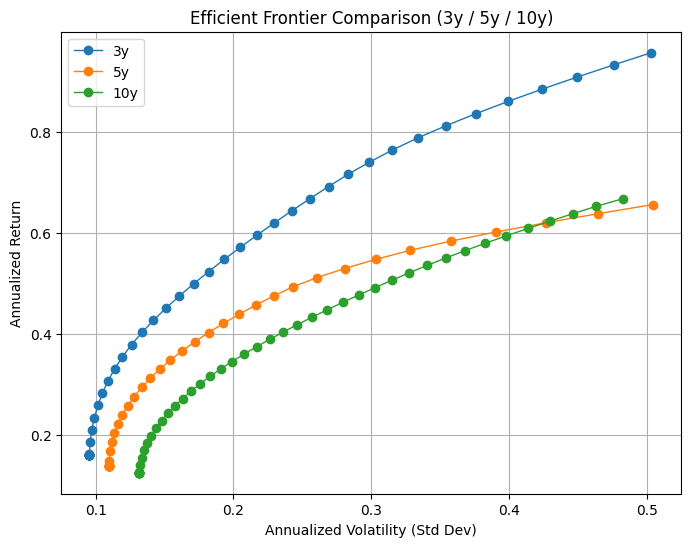

AUTOMATED RUN SUMMARY AND INTERPRETATION

Window: last 3 years (2022-11-21 to 2025-11-21)
  Tickers kept: 100; dropped: 0
  Sigma condition number: 6.266e+02
  Frontier points: 46; AUC (ret vs risk): 0.284688
  Interpretation: Sigma is well-conditioned.

Window: last 5 years (2020-11-21 to 2025-11-21)
  Tickers kept: 100; dropped: 0
  Sigma condition number: 1.340e+03
  Frontier points: 46; AUC (ret vs risk): 0.204046
  Interpretation: Sigma is moderately conditioned.

Window: last 10 years (2015-11-21 to 2025-11-21)
  Tickers kept: 97; dropped: 3
  Dropped tickers: ['FOX', 'FOXA', 'ROKU']
  Sigma condition number: 5.539e+02
  Frontier points: 45; AUC (ret vs risk): 0.167233
  Interpretation: Sigma is well-conditioned.

Cross-window comparison (AUC scores)
  3y AUC = 0.2846884662412561
  5y AUC = 0.20404611126518393
  10y AUC = 0.16723265779912633
Overall, the 3y window has the highest AUC. Its frontier provides the best return-for-risk tradeoff in this analysis.

Running detailed sing

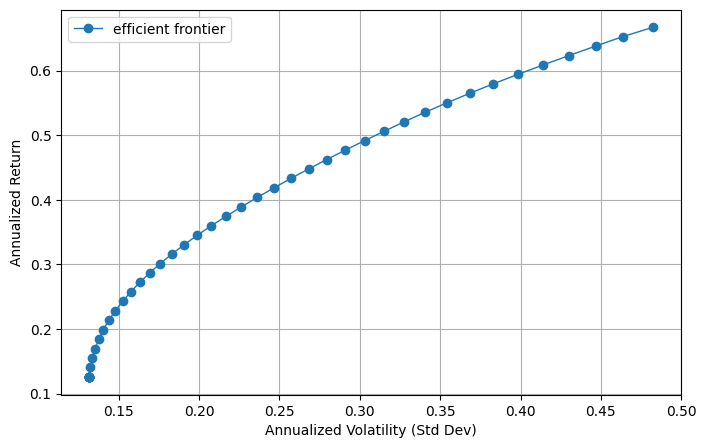

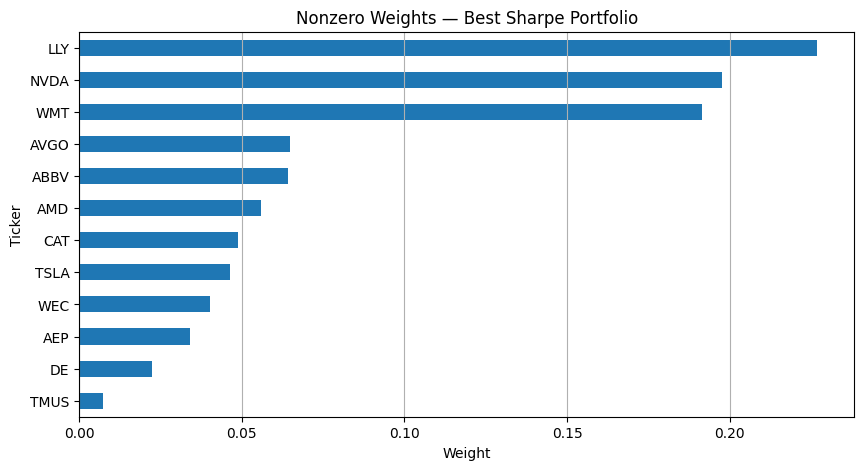


PORTFOLIO REPORT
Data period: 2015-11-21 to 2025-11-21
Number of assets: 97
Best Sharpe Ratio Portfolio:
  Expected Return: 0.3747
  Risk (Volatility): 0.2168
  Sharpe Ratio: 1.5669
  Allocation:
    AAPL: 0.0000
    ABBV: 0.0641
    ADBE: 0.0000
    ADSK: -0.0000
    AEP: 0.0340
    AMAT: -0.0000
    AMD: 0.0558
    AMGN: 0.0000
    AMZN: -0.0000
    AVGO: 0.0649
    AXP: 0.0000
    BA: -0.0000
    BAC: -0.0000
    BKNG: -0.0000
    BLK: -0.0000
    BMY: 0.0000
    BP: 0.0000
    C: -0.0000
    CAT: 0.0487
    CHTR: 0.0000
    CMCSA: -0.0000
    COP: 0.0000
    COST: 0.0000
    CRM: 0.0000
    CSCO: -0.0000
    CVX: 0.0000
    DE: 0.0224
    DIS: -0.0000
    DUK: 0.0000
    ED: 0.0000
    EXC: 0.0000
    FDX: -0.0000
    GE: -0.0000
    GILD: -0.0000
    GOOGL: -0.0000
    GS: -0.0000
    HAL: -0.0000
    HD: -0.0000
    HON: -0.0000
    IBM: -0.0000
    INTC: -0.0000
    JNJ: -0.0000
    JPM: 0.0000
    KLAC: -0.0000
    KO: 0.0000
    LLY: 0.2269
    LMT: -0.0000
    LRCX: -0.0000


In [114]:
#in our main function we evalulate efficent fontiers ,prints the no of dropped tickers,conditioner number,AUC 
#compares the statbilty and runs single window analyis for the longest window.
#we are storing all the outputs in csv files.

results = compare_frontiers_for_windows(TICKERS, lookback_years=LOOKBACK_YEARS, end=END, n_points=N_POINTS, l2_reg=L2_REG)

if results:
    print("AUTOMATED RUN SUMMARY AND INTERPRETATION")
    aucs = {}
    for yrs, r in results.items():
        ef = r['ef']
        weights = r['weights']
        kept = r['kept']
        dropped = r['dropped']
        Sigma = r['Sigma']
            # condition number
        try:
            cond = np.linalg.cond(Sigma)
        except Exception:
            cond = np.nan
        print("")
        print(f"Window: last {yrs} years ({r['start']} to {r['end']})")
        print(f"  Tickers kept: {len(kept)}; dropped: {len(dropped)}")
        if dropped:
            print(f"  Dropped tickers: {dropped}")
        print(f"  Sigma condition number: {cond:.3e}")
            # compute AUC (area under curve)
        try:
            risk = ef['risk'].values
            ret = ef['ret'].values
            mask = ~np.isnan(risk) & ~np.isnan(ret)
            if mask.sum() >= 3:
                auc = np.trapezoid(ret[mask], risk[mask])
            else:
                auc = np.nan
        except Exception:
            auc = np.nan
        aucs[yrs] = auc
        print(f"  Frontier points: {len(ef)}; AUC (ret vs risk): {auc:.6f}")
     
        if not np.isnan(cond):
            if cond < 1e3:
                print("  Interpretation: Sigma is well-conditioned.")
            elif cond < 1e7:
                print("  Interpretation: Sigma is moderately conditioned.")
            else:
                print("  Interpretation: Sigma is ill-conditioned.")
        # Compare AUCs to state which window gives stronger frontier
    print("")
    print("Cross-window comparison (AUC scores)")
    for yrs, auc in sorted(aucs.items()):
        print(f"  {yrs}y AUC = {auc}")
        # pick best AUC
    try:
        best_window = max(aucs, key=lambda k: (aucs[k] if not np.isnan(aucs[k]) else -np.inf))
        print(f"Overall, the {best_window}y window has the highest AUC. Its frontier provides the best return-for-risk tradeoff in this analysis.")
    except Exception:
        print("Could not determine best window by AUC because of insufficient data.")
    print("")
        # Run detailed analysis on the longest window
    longest = max(results.keys())
    kept = results[longest]['kept']
    start_used = results[longest]['start']
    print(f"Running detailed single-window analysis on the {longest}y window using {len(kept)} tickers")
    print("")
    analyze_single_window(kept, start=start_used, end=END, n_points=N_POINTS, allow_short=ALLOW_SHORT, l2_reg=L2_REG)
else:
    print("No valid windows produced results, check data availability or tickers list.")
